# Weaviate Challenge Solution
## William Pugsley

We will explore the [LinkedIn job postings (2023-2024) dataset](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/) from Kaggle. The purpose of this project is to cluster job postings in the machine learning field. We will engineer useful data fields, add them to a Weaviate collection using Cohere embedding, and extract the job postings related to machine learning using semantic search.

Requires the postings.csv file from Kaggle to be in the directory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import os
import weaviate
import weaviate.classes as wvc
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder

In [2]:
plt.rcParams['font.size'] = 16 #make the font size of plots larger

# Preliminaries

In [3]:
#reads a file that holds all the API keys and URLs

# open the file in read mode
with open("secrets.txt", 'r') as file:
    # read lines from the file
    lines = file.readlines()

secrets = {} #private dictionary for API keys

# iterate through each line and split key-value pairs
for line in lines:
    key, value = line.strip().split(',')
    secrets[key.strip()] = value.strip()

# Data Exploration

We will start by exploring the dataset, extracting the relevant instances, and engineering new fields.

In [4]:
df_postings_raw = pd.read_csv("postings.csv") #load data

In [5]:
df_postings_raw.head(2) #preview data

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY


A lot of values are NaN. We will need to drop these points or fill in the blanks.

In [6]:
df_postings_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [7]:
#where are the min and max salaries both not NaN?
not_na_col1 = df_postings_raw["min_salary"].notna()
not_na_col2 = df_postings_raw["max_salary"].notna()

both_not_na = not_na_col1 & not_na_col2

# Count the number of rows where both columns are not NaN
num_rows = both_not_na.sum()
print(num_rows)

29793


Every instance that has a min salary also has a max salary. What about for the med salary field?

In [8]:
not_na_col1 = df_postings_raw["min_salary"].notna()
not_na_col2 = df_postings_raw["med_salary"].notna()

both_not_na = not_na_col1 & not_na_col2

# Count the number of rows where both columns are not NaN
num_rows = both_not_na.sum()
print(num_rows)

0


There are no instance of a job posting having a median salary and a min/max salary. 

In [9]:
df_postings = df_postings_raw.copy()

In [10]:
df_postings.loc[df_postings_raw["min_salary"].notna(), "med_salary"] = (df_postings_raw["min_salary"][df_postings_raw["min_salary"].notna()]
                                                                         + df_postings_raw["max_salary"][df_postings_raw["max_salary"].notna()])/2
#we can drop the max_salary and min_salary columns since we combined them
df_postings = df_postings.drop(["min_salary", "max_salary"], axis=1)

Every posting with a salary has a pay period field. We will convert all salaries to yearly salaries.

We will assume 40 hours/week of working and 50 salaried weeks in the year.

In [11]:
hourly_indices = df_postings["pay_period"] == "HOURLY"
df_postings.loc[hourly_indices, "med_salary"] = df_postings["med_salary"][hourly_indices]*40*50

weekly_indices = df_postings["pay_period"] == "WEEKLY"
df_postings.loc[weekly_indices, "med_salary"] = df_postings["med_salary"][weekly_indices]*50

biweekly_indices = df_postings["pay_period"] == "BIWEEKLY"
df_postings.loc[biweekly_indices, "med_salary"] = df_postings["med_salary"][biweekly_indices]*25

monthly_indices = df_postings["pay_period"] == "MONTHLY"
df_postings.loc[monthly_indices, "med_salary"] = df_postings["med_salary"][monthly_indices]*12

We also need to convert currencies to USD for a fair comparison.

In [86]:
df_postings_raw["currency"].unique()

array(['USD', nan, 'CAD', 'BBD', 'EUR', 'AUD', 'GBP'], dtype=object)

In [12]:
#current exchange rates
CAD_to_USD = 0.73
BBD_to_USD = 0.50
EUR_to_USD = 1.08
AUD_to_USD = 0.67
GBP_to_USD = 1.29

In [15]:
cad_indices = df_postings["currency"] == "CAD"
df_postings.loc[cad_indices, "med_salary"] = df_postings["med_salary"][cad_indices].mul(CAD_to_USD)

bbd_indices = df_postings["currency"] == "BBD"
df_postings.loc[bbd_indices, "med_salary"] = df_postings["med_salary"][bbd_indices].mul(BBD_to_USD)

eur_indices = df_postings["currency"] == "EUR"
df_postings.loc[eur_indices, "med_salary"] = df_postings["med_salary"][eur_indices].mul(EUR_to_USD)

aud_indices = df_postings["currency"] == "AUD"
df_postings.loc[aud_indices, "med_salary"] = df_postings["med_salary"][aud_indices].mul(AUD_to_USD)

gbp_indices = df_postings["currency"] == "GBP"
df_postings.loc[gbp_indices, "med_salary"] = df_postings["med_salary"][gbp_indices].mul(GBP_to_USD)

We are only interested in job postings that have descriptions, titles, salaries, locations, views, applications, and experience levels. 

We will remove all other columns.

In [16]:
useful_fields = ["med_salary", "description", "title", "job_id", "location", "applies", "views", "formatted_experience_level"]

In [17]:
df_postings = df_postings.drop([col for col in df_postings.columns if col not in useful_fields], axis=1)

Drop all remaining samples with NaNs in any of the useful fields.

In [18]:
df_postings = df_postings.dropna(axis=0, how='any').reset_index(drop=True)

In [19]:
df_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      6718 non-null   int64  
 1   title                       6718 non-null   object 
 2   description                 6718 non-null   object 
 3   location                    6718 non-null   object 
 4   views                       6718 non-null   float64
 5   med_salary                  6718 non-null   float64
 6   applies                     6718 non-null   float64
 7   formatted_experience_level  6718 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 420.0+ KB


# Adding Data to Weaviate Database

In [20]:
#connect to weaviate cloud server
#we will use Cohere for the embedding
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=secrets["WCD_URL"],
    auth_credentials=weaviate.auth.AuthApiKey(secrets["WCD_API_KEY"]),
    headers={"X-Cohere-Api-Key": secrets["COHERE_API_KEY"]}
    #headers={"X-OpenAI-Api-Key": secrets["OPENAI_API_KEY"]}
)

In [21]:
#create the collection
postings = client.collections.create(
        name="Postings",
        vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_cohere(),
        generative_config=wvc.config.Configure.Generative.cohere()
    )

In [22]:
postings = client.collections.get("Postings")

with postings.batch.dynamic() as batch:
    for idx, row in df_postings.iterrows(): #iterate over all datapoint
        #code for testing a subset of postings
        #df_postings.sample(100, replace=False).iterrows(): #iterate over sample of datapoints
        #df_postings.iterrows(): #iterate over all datapoint

        datapoint = {}
        for col in df_postings.columns: #add every column to the database
            datapoint[col] = row[col]
        batch.add_object(datapoint) #add datapoint to the batch

How many data points actually ended up in the collection?

In [23]:
postings = client.collections.get("Postings")
try:
    count = 0
    for item in postings.iterator():
        count += 1
finally:
    client.close()
print(f"There are {count} data points in the collection.")

There are 6718 data points in the collection.


This is all 6718 data points.

# Query the Database

Now that we have the data in the Weaviate database, we can query it for job postings related to machine learning and AI.

In [24]:
#connect to weaviate cloud server
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=secrets["WCD_URL"],
    auth_credentials=weaviate.auth.AuthApiKey(secrets["WCD_API_KEY"]),
    headers={"X-Cohere-Api-Key": secrets["COHERE_API_KEY"]}
    #headers={"X-OpenAI-Api-Key": secrets["OPENAI_API_KEY"]}
)

try:
    postings = client.collections.get("Postings")

    ml_responses = postings.query.near_text( #machine learning postings
        query="machine learning",
        limit=200
    )


finally:
    client.close()

How many objects did this return?

In [25]:
len(ml_responses.objects)

200

Inspect one of the objects.

In [26]:
ml_responses.objects[13].properties

{'description': 'Overview\n\nThe Data Scientist I is focused on machine learning solutions in Healthcare Technology and builds value-oriented, production level machine learning solutions. This is not a research oriented data scientist; instead you will apply your knowledge and experience to real world problems, and seek to utilize Artificial Intelligence and Machine Learning to reduce the cost of healthcare and improve health quality and outcomes. With access to dedicated on premise and cloud based big data solutions, the team can work with a vast amount of structured and unstructured data including claims, membership, physician demographics, medical records and others to begin to solve some of the most pressing healthcare issues of our time. A Data Scientist at Cotiviti will be given the opportunity to work directly with a team of healthcare professionals including analysts, clinicians, coding specialists, auditors and innovators to set aggressive goals and execute on them with the te

# Analyze the ML Job Postings Data

In [27]:
#create a dataframe of the ML responses so that we can easily plot and use the data
ml_df = pd.DataFrame()
for col in df_postings.columns:
    ml_df[col] = pd.Series([post.properties[col] for post in ml_responses.objects])

In [28]:
#encode categorical experience labels. This will allow us to plot the relationship between experience levels and other fields
experience_labels ={
    "Internship": 0,
    "Entry level": 1,
    "Associate": 2,
    "Mid-Senior level": 3,
    "Director": 4
}
#add this info to a new column
ml_df["experience_level_encoded"] = [experience_labels[entry] for entry in ml_df["formatted_experience_level"]]

In [29]:
ml_df.head() #inspect the new dataframe

,job_id,title,description,location,views,med_salary,applies,formatted_experience_level,experience_level_encoded
0,3.905215e+09,Machine Learning Engineer - Remote,Machine Learning Engineer - Remote - Competiti...,"Chicago, IL",15.0,170000.0,4.0,Mid-Senior level,3
1,3.903452e+09,AI/ML Engineering Manager,Your role at Sephora:This is an opportunity fo...,San Francisco Bay Area,50.0,190720.0,8.0,Mid-Senior level,3
2,3.905212e+09,Machine Learning Engineer - Remote,Machine Learning Engineer - Remote - Competiti...,"Los Angeles County, CA",13.0,170000.0,5.0,Mid-Senior level,3
3,3.905869e+09,Lead Machine Learning Engineer,Who We Are\n\nWe are a small deep-tech startup...,United States,14.0,200000.0,3.0,Mid-Senior level,3
4,3.888941e+09,Staff Machine Learning Engineer,Join our team at Workiva as a Staff Machine Le...,United States,11.0,162000.0,1.0,Mid-Senior level,3


### Are the numeric fields highly correlated?

In [30]:
ml_df[["applies", "views", "med_salary", "experience_level_encoded"]].corr(numeric_only=True)

,applies,views,med_salary,experience_level_encoded
applies,1.000000,0.931381,-0.036938,0.108489
views,0.931381,1.000000,0.045467,0.157600
med_salary,-0.036938,0.045467,1.000000,0.365133
experience_level_encoded,0.108489,0.157600,0.365133,1.000000


The numbers of views and applications are very strongly correlated. Let's plot the relation.

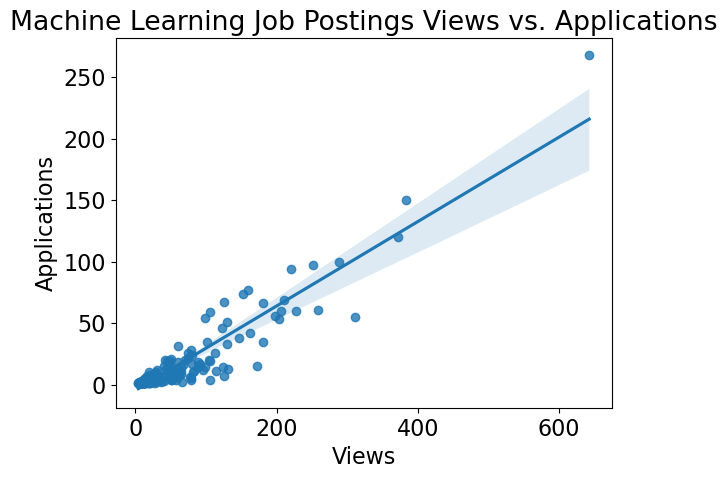

In [31]:
plt.figure()
sns.regplot(x="views", y="applies", data=ml_df[["views", "applies"]])
plt.xlabel("Views")
plt.ylabel("Applications")
plt.title("Machine Learning Job Postings Views vs. Applications")
plt.show()

In [41]:
result = linregress(ml_df['views'].to_numpy(), ml_df['applies'].to_numpy())
print(result)

LinregressResult(slope=0.34292321467744613, intercept=-4.683683361970903, rvalue=0.9313808177113774, pvalue=7.80966600626731e-89, stderr=0.009525630431731142, intercept_stderr=0.9309704229484824)


Unsurprisingly, the more views a posting gets, the more applicants it is likely to receive. There is a ratio of ~0.34 applications per view.

### How many jobs postings are there for each level of experience?

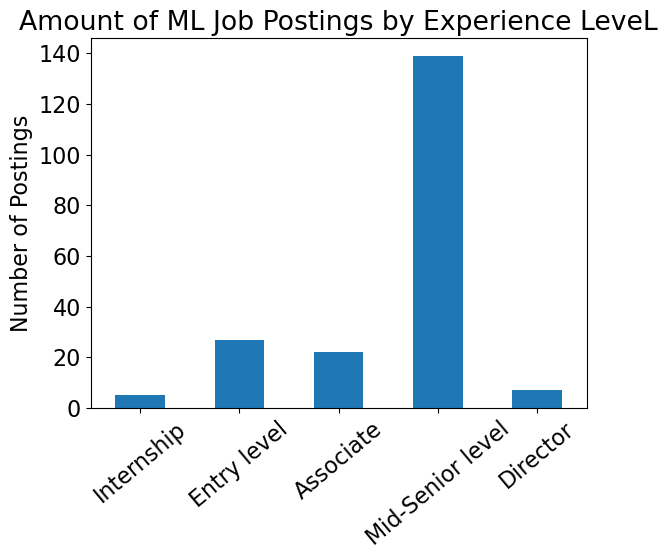

In [53]:
ml_df.formatted_experience_level.value_counts()[["Internship", "Entry level", "Associate", "Mid-Senior level", "Director"]].plot(kind='bar', 
                                                                                                        xlabel="", 
                                                                                                        ylabel="Number of Postings",
                                                                                                        title="Amount of ML Job Postings by Experience LeveL")
plt.xticks(rotation=40)
plt.show()

There are more mid-senior level job postings than all other levels combined. This makes sense because it is the most broad category encompassing the most numbers of years of experience.

### How does salary change with experience?

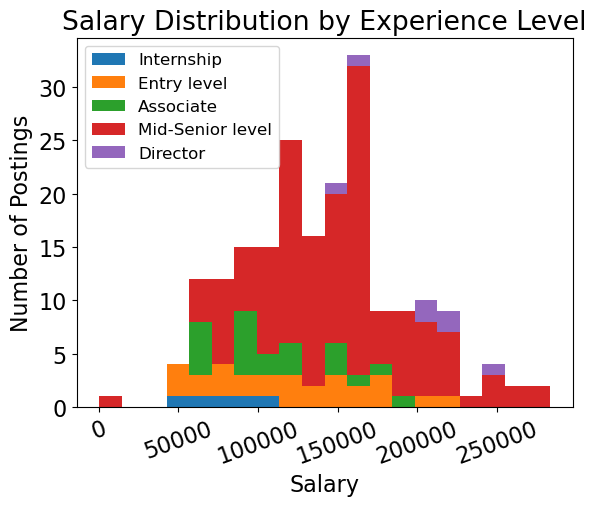

In [54]:
plt.figure()

#put the data in a form that is useable by pyplot
levels = ["Internship", "Entry level", "Associate", "Mid-Senior level", "Director"]
data = [ml_df["med_salary"][ml_df["formatted_experience_level"] == level] for level in levels]
plt.hist(data, bins=20, label=levels, histtype='bar', stacked=True)

plt.legend(loc="upper left", prop={'size': 12})
plt.xticks(rotation=20)
plt.xlabel("Salary")
plt.ylabel("Number of Postings")
plt.title("Salary Distribution by Experience Level")
plt.show()

There is a trend towards higher salaries as experience levels increase. However, there is a large variance in salaries at all experience levels.